In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15

import lightgbm as lgb
import xgboost as xgb
import time
import datetime

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import Ridge, RidgeCV
import gc
from catboost import CatBoostRegressor
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

train = pd.read_csv('train.csv',nrows=60000000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})

/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.16.0-unknown is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [2]:
train.head()

,acoustic_data,time_to_failure
0,12,1.469099998474121
1,6,1.469099998474121
2,8,1.469099998474121
3,5,1.469099998474121
4,8,1.469099998474121


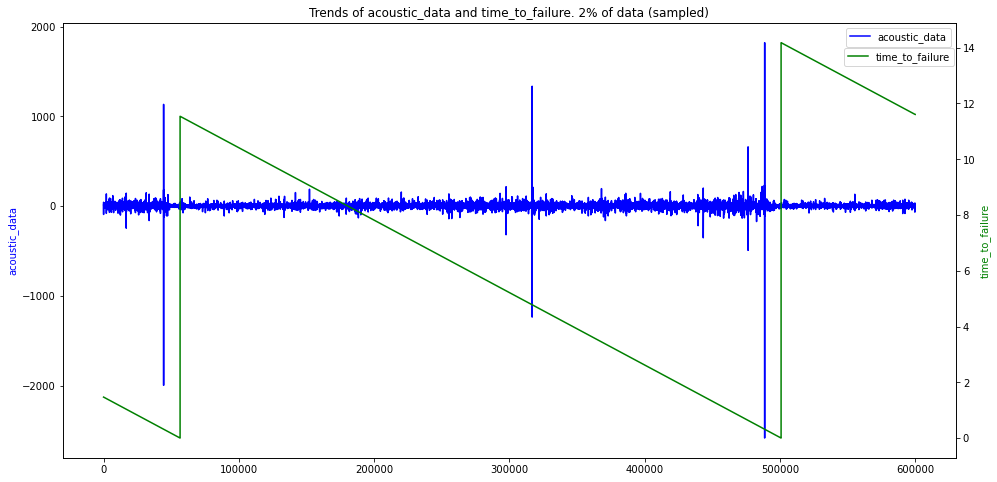

In [3]:
train_acoustic_data_small = train['acoustic_data'].values[::100]
train_time_to_failure_small = train['time_to_failure'].values[::100]

fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("Trends of acoustic_data and time_to_failure. 2% of data (sampled)")
plt.plot(train_acoustic_data_small, color='b')
ax1.set_ylabel('acoustic_data', color='b')
plt.legend(['acoustic_data'])
ax2 = ax1.twinx()
plt.plot(train_time_to_failure_small, color='g')
ax2.set_ylabel('time_to_failure', color='g')
plt.legend(['time_to_failure'], loc=(0.875, 0.9))
plt.grid(False)

del train_acoustic_data_small
del train_time_to_failure_small

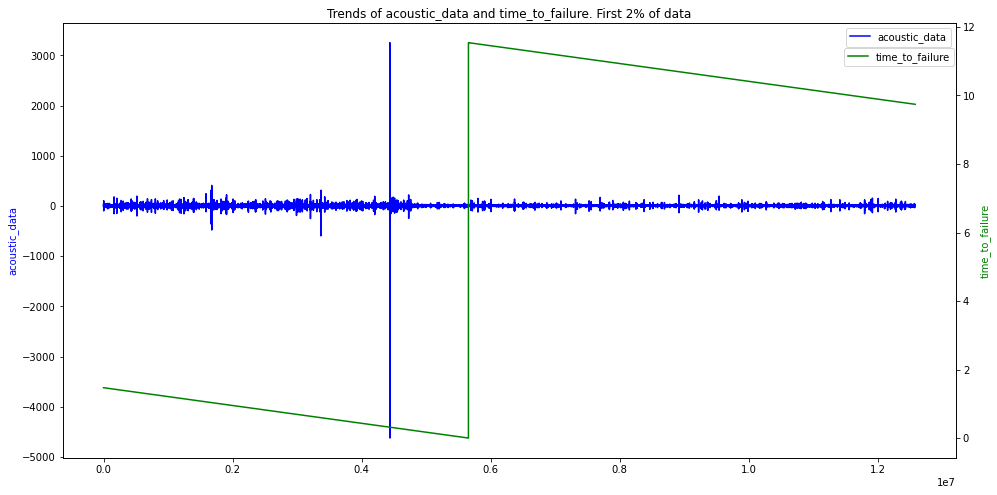

In [4]:
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("Trends of acoustic_data and time_to_failure. First 2% of data")
plt.plot(train['acoustic_data'].values[:12582910], color='b')
ax1.set_ylabel('acoustic_data', color='b')
plt.legend(['acoustic_data'])
ax2 = ax1.twinx()
plt.plot(train['time_to_failure'].values[:12582910], color='g')
ax2.set_ylabel('time_to_failure', color='g')
plt.legend(['time_to_failure'], loc=(0.875, 0.9))
plt.grid(False)

In [5]:
segments = int(np.floor(train.shape[0] / 150000))
print(segments)
tqdm_notebook(range(segments))

400


  0%|          | 0/400 [00:00<?, ?it/s]

### Feature engineering

Let's create some new features.

Why 150000? Test segments are 150000 each. At first I create features similar to baseline kernel, but with more aggregations.

In [6]:
# Create a training file with simple derived features
rows = 150000
segments = int(np.floor(train.shape[0] / rows)) # 6 milyon için 40

X_train = pd.DataFrame(index=range(segments), dtype=np.float64,
                        columns=['ave', 'std', 'max', 'min',
                               'av_change_abs', 'av_change_rate', 'abs_max', 'abs_min',
                               'std_first_50000', 'std_last_50000', 'std_first_10000', 'std_last_10000',
                               'avg_first_50000', 'avg_last_50000', 'avg_first_10000', 'avg_last_10000',
                               'min_first_50000', 'min_last_50000', 'min_first_10000', 'min_last_10000',
                               'max_first_50000', 'max_last_50000', 'max_first_10000', 'max_last_10000'])
y_train = pd.DataFrame(index=range(segments), dtype=np.float64,
                        columns=['time_to_failure'])

total_mean = train['acoustic_data'].mean()
total_std = train['acoustic_data'].std()
total_max = train['acoustic_data'].max()
total_min = train['acoustic_data'].min()
total_sum = train['acoustic_data'].sum()
total_abs_max = np.abs(train['acoustic_data']).sum()

for segment in tqdm_notebook(range(segments)): #Custom özellikleri loop ile ekliyor
    seg = train.iloc[segment*rows:segment*rows+rows] # Belirlediği segment kadar veri alıyor
    x = seg['acoustic_data'].values
    y = seg['time_to_failure'].values[-1]
    
    y_train.loc[segment, 'time_to_failure'] = y
    X_train.loc[segment, 'ave'] = x.mean()
    X_train.loc[segment, 'std'] = x.std()
    X_train.loc[segment, 'max'] = x.max()
    X_train.loc[segment, 'min'] = x.min()
    
    
    X_train.loc[segment, 'av_change_abs'] = np.mean(np.diff(x))
    X_train.loc[segment, 'av_change_rate'] = np.mean(np.nonzero((np.diff(x) / x[:-1]))[0])
    X_train.loc[segment, 'abs_max'] = np.abs(x).max()
    X_train.loc[segment, 'abs_min'] = np.abs(x).min()
    
    X_train.loc[segment, 'std_first_50000'] = x[:50000].std()
    X_train.loc[segment, 'std_last_50000'] = x[-50000:].std()
    X_train.loc[segment, 'std_first_10000'] = x[:10000].std()
    X_train.loc[segment, 'std_last_10000'] = x[-10000:].std()
    
    X_train.loc[segment, 'avg_first_50000'] = x[:50000].mean()
    X_train.loc[segment, 'avg_last_50000'] = x[-50000:].mean()
    X_train.loc[segment, 'avg_first_10000'] = x[:10000].mean()
    X_train.loc[segment, 'avg_last_10000'] = x[-10000:].mean()
    
    X_train.loc[segment, 'min_first_50000'] = x[:50000].min()
    X_train.loc[segment, 'min_last_50000'] = x[-50000:].min()
    X_train.loc[segment, 'min_first_10000'] = x[:10000].min()
    X_train.loc[segment, 'min_last_10000'] = x[-10000:].min()
    
    X_train.loc[segment, 'max_first_50000'] = x[:50000].max()
    X_train.loc[segment, 'max_last_50000'] = x[-50000:].max()
    X_train.loc[segment, 'max_first_10000'] = x[:10000].max()
    X_train.loc[segment, 'max_last_10000'] = x[-10000:].max()

  0%|          | 0/400 [00:00<?, ?it/s]

In [7]:
print(f'{X_train.shape[0]} samples in new train data.')

400 samples in new train data.


Let's see all new features

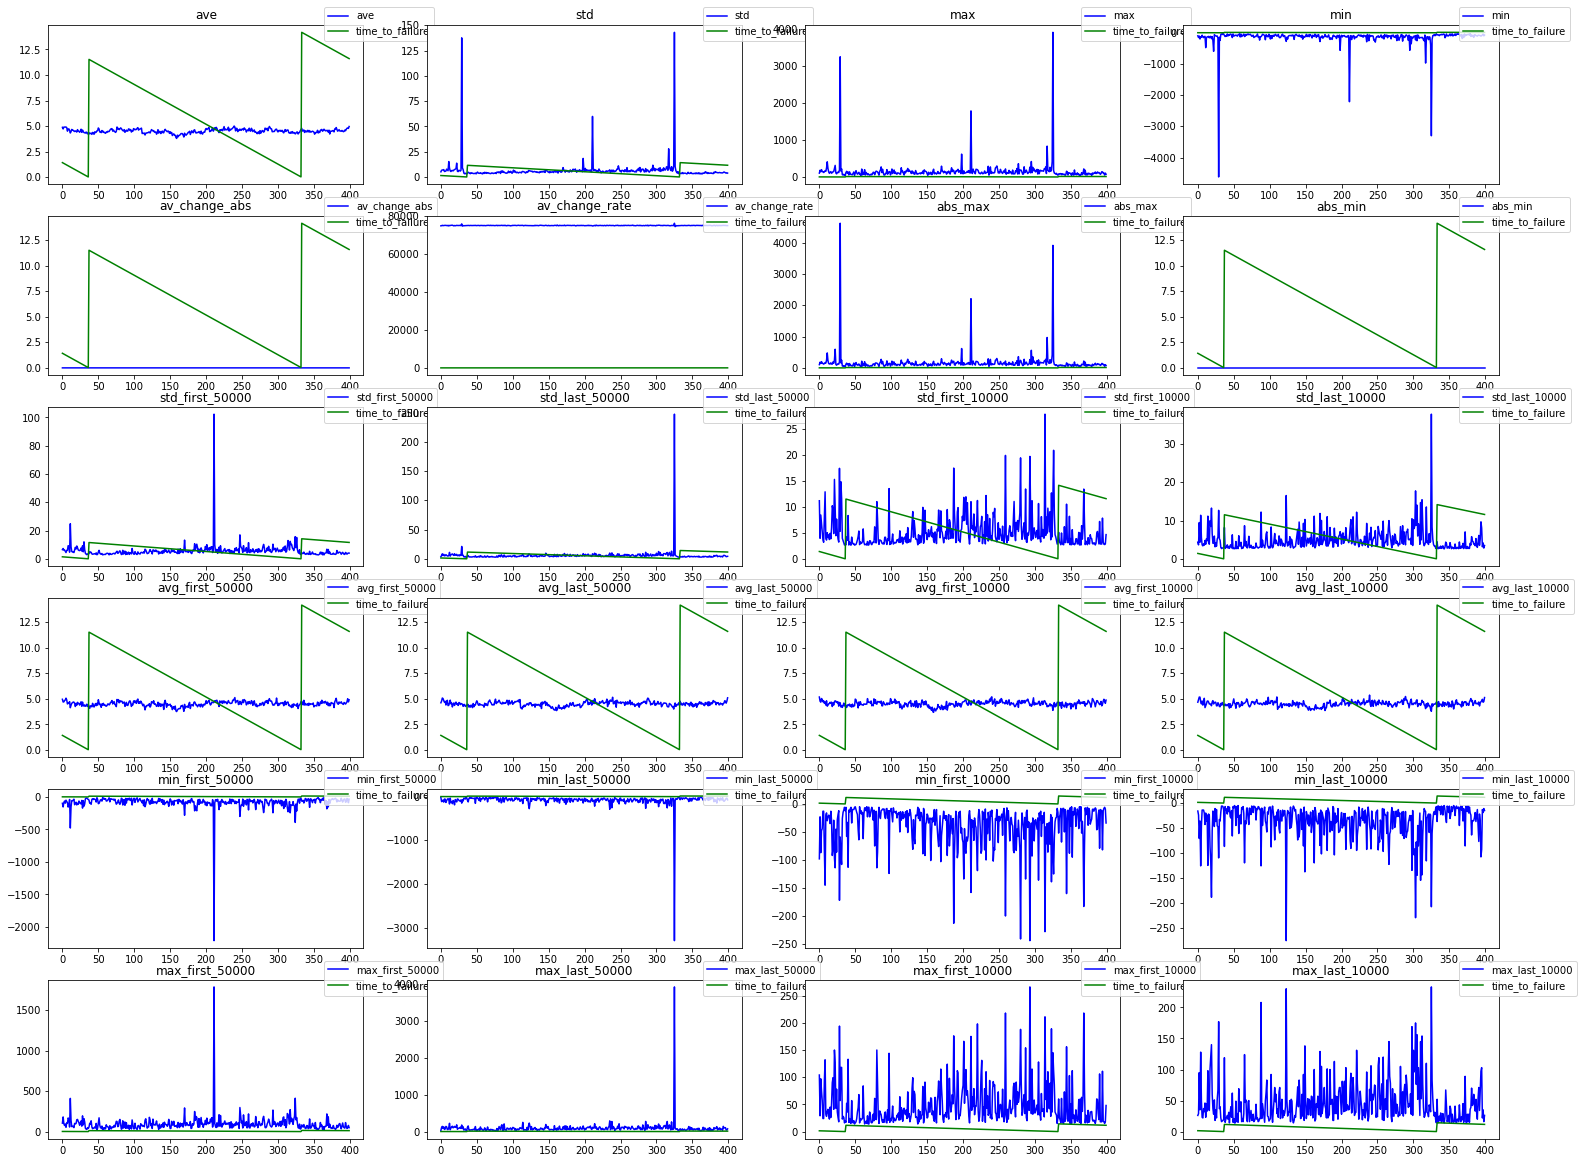

In [8]:
plt.figure(figsize=(26, 24))
for i, col in enumerate(X_train.columns):
    plt.subplot(7, 4, i + 1)
    plt.plot(X_train[col], color='blue')
    plt.title(col)
    ax1.set_ylabel(col, color='b')

    ax2 = ax1.twinx()
    plt.plot(y_train, color='g')
    ax2.set_ylabel('time_to_failure', color='g')
    plt.legend([col, 'time_to_failure'], loc=(0.875, 0.9))
    plt.grid(False)

In [9]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)

  0%|          | 0/2624 [00:00<?, ?it/s]

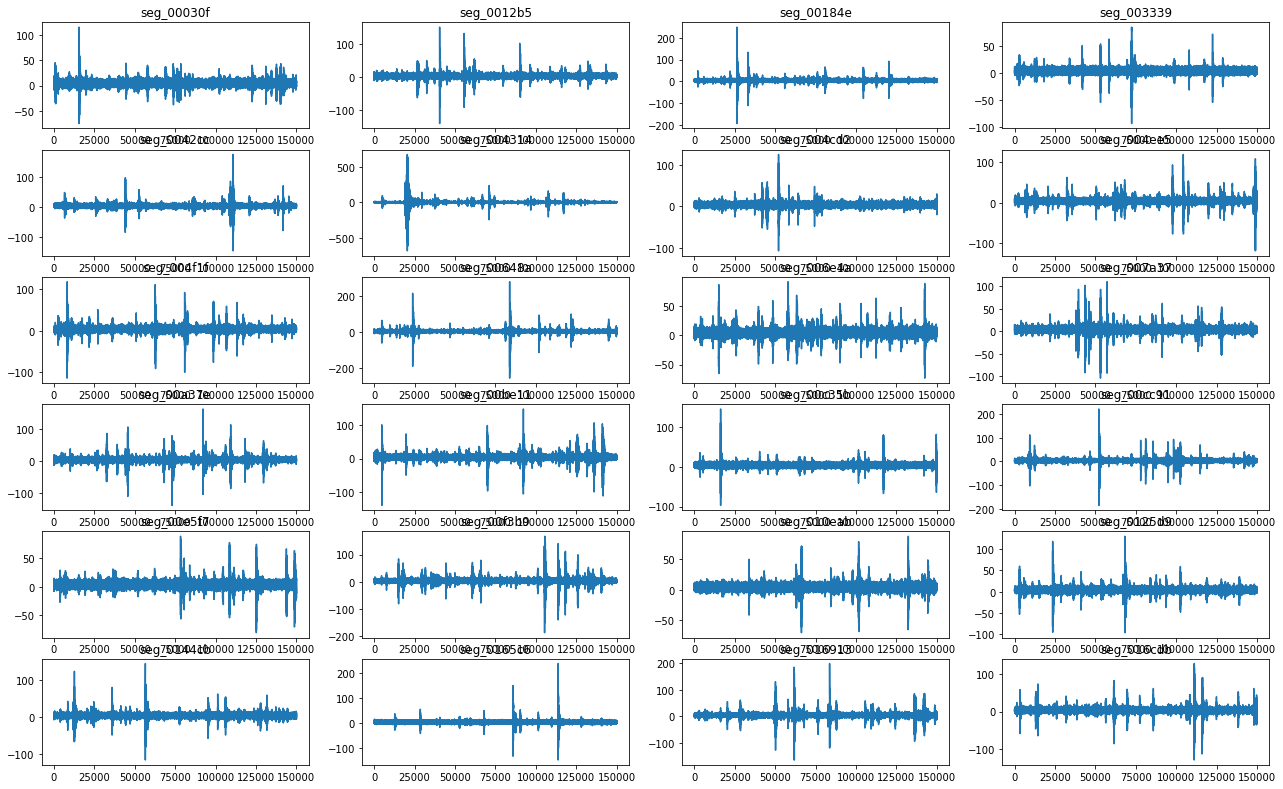

In [11]:
submission = pd.read_csv('sample_submission.csv', index_col='seg_id')
X_test = pd.DataFrame(columns=X_train.columns, dtype=np.float64, index=submission.index)
plt.figure(figsize=(22, 16))

for i, seg_id in enumerate(tqdm_notebook(X_test.index)):
    seg = pd.read_csv('test/' + seg_id + '.csv')
    
    x = seg['acoustic_data'].values
    X_test.loc[seg_id, 'ave'] = x.mean()
    X_test.loc[seg_id, 'std'] = x.std()
    X_test.loc[seg_id, 'max'] = x.max()
    X_test.loc[seg_id, 'min'] = x.min()
        
    X_test.loc[seg_id, 'av_change_abs'] = np.mean(np.diff(x))
    X_test.loc[seg_id, 'av_change_rate'] = np.mean(np.nonzero((np.diff(x) / x[:-1]))[0])
    X_test.loc[seg_id, 'abs_max'] = np.abs(x).max()
    X_test.loc[seg_id, 'abs_min'] = np.abs(x).min()
    
    X_test.loc[seg_id, 'std_first_50000'] = x[:50000].std()
    X_test.loc[seg_id, 'std_last_50000'] = x[-50000:].std()
    X_test.loc[seg_id, 'std_first_10000'] = x[:10000].std()
    X_test.loc[seg_id, 'std_last_10000'] = x[-10000:].std()
    
    X_test.loc[seg_id, 'avg_first_50000'] = x[:50000].mean()
    X_test.loc[seg_id, 'avg_last_50000'] = x[-50000:].mean()
    X_test.loc[seg_id, 'avg_first_10000'] = x[:10000].mean()
    X_test.loc[seg_id, 'avg_last_10000'] = x[-10000:].mean()
    
    X_test.loc[seg_id, 'min_first_50000'] = x[:50000].min()
    X_test.loc[seg_id, 'min_last_50000'] = x[-50000:].min()
    X_test.loc[seg_id, 'min_first_10000'] = x[:10000].min()
    X_test.loc[seg_id, 'min_last_10000'] = x[-10000:].min()
    
    X_test.loc[seg_id, 'max_first_50000'] = x[:50000].max()
    X_test.loc[seg_id, 'max_last_50000'] = x[-50000:].max()
    X_test.loc[seg_id, 'max_first_10000'] = x[:10000].max()
    X_test.loc[seg_id, 'max_last_10000'] = x[-10000:].max()
    
    if i < 24:
        plt.subplot(7, 4, i + 1)
        plt.plot(seg['acoustic_data'])
        plt.title(seg_id)
    
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [29]:
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, mean_absolute_error


Xtrain, Xtest, ytrain, ytest = train_test_split(X_train_scaled, y_train, test_size=0.2, random_state=42)
regressor = {
    "SGD": SGDRegressor(),
    "KNN": KNeighborsRegressor(),  
    "DT": DecisionTreeRegressor(),
    "RF": RandomForestRegressor(max_depth=3, random_state=2),
    "SVM": SVR(),
    "MLP": MLPRegressor(max_iter=1000),
    "XGB": XGBRegressor(),
    "LGBM": LGBMRegressor(),
    'CatBoost':CatBoostRegressor(iterations=10000,loss_function='MAE',silent=True)
}

results = pd.DataFrame(columns=["Regressor", "mae"])
for name, clf in regressor.items():
    model = clf
    clf.fit(Xtrain,ytrain)
    predictions = clf.predict(Xtest)
    predictions=pd.DataFrame(predictions,columns=['Predictions'])
    results = results.append({
        "Regressor": name,
        'mae':mean_absolute_error(ytest,predictions),
    }, ignore_index=True)
    
results

,Regressor,mae
0,SGD,3.179570639225894
1,KNN,2.937877075280994
2,DT,3.397983738966286
3,RF,2.276988814923331
4,SVM,2.867202408135696
5,MLP,2.43761183562489
6,XGB,2.449100913666189
7,LGBM,2.266248654921341
8,CatBoost,2.194966505249929


In [35]:
clf=XGBRegressor()
#clf.fit(X_train_scaled,y_train)

params = {
    "learning_rate": (0.1, 0.01, 0.001),
    "max_depth": (5,6,7,8),
    'n_estimators':(100,120,130,150),
    'base_score': (0.1,0.25,0.5,0.6,0.75,0.8,0.9)
}
clf = GridSearchCV(clf, params, cv=10)
clf.fit(X_train_scaled, y_train)
prediction_xgb=clf.predict(X_test_scaled)
print("Best hyperparameter:", clf.best_params_)

Best hyperparameter: {'base_score': 0.75, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}


In [33]:
clf=LGBMRegressor()

params = {
    "learning_rate": (0.1,0.3, 0.01, 0.001),
    'num_leaves': (29,31,33,35,37),
    "max_depth": (-1,5,6,7,8),
    'n_estimators':(100,120,130,150),
}
clf = GridSearchCV(clf, params, cv=10)
clf.fit(X_train_scaled, y_train)

prediction_lgb=clf.predict(X_test_scaled)
print("Best hyperparameter:", clf.best_params_)

Best hyperparameter: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 150, 'num_leaves': 29}


In [36]:
clf=CatBoostRegressor(silent=True)
params = {
    "learning_rate": (0.1,0.3, 0.01, 0.001, 0.0001,0.00001),
    "max_depth": (5,6,7,8),
    'n_estimators':(120,130,150),
}
clf = GridSearchCV(clf, params, cv=10)
clf.fit(X_train_scaled, y_train)
prediction_cat=clf.predict(X_test_scaled)
print("Best hyperparameter:", clf.best_params_)

Best hyperparameter: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 120}


In [40]:
submission['time_to_failure'] = (prediction_lgb + prediction_xgb + prediction_cat) / 3
print(submission.head())
submission.to_csv('submission.csv')

               time_to_failure
seg_id                        
seg_00030f   5.826792747693649
seg_0012b5   5.187816172492949
seg_00184e   5.492481413048324
seg_003339  10.764044631689027
seg_0042cc   6.365895695456833


In [41]:
!kaggle competitions submit -c LANL-Earthquake-Prediction -f submission.csv -m "Hello There!"

100%|██████████████████████████████████████| 74.8k/74.8k [00:01<00:00, 46.1kB/s]
Successfully submitted to LANL Earthquake Prediction